Spatial Interaction models

# Models and calibration
For this section, you will be given a “symbolic” population and the number of jobs for the stations in the underground. You will also be given the number of people that commute from one station to another, through an OD matrix.

## 3.1 Spatial Interaction models 8'
_Briefly introduce the spatial interaction models covered in the lectures __using equations and defining the terms__, taking particular care in explaining the role of the parameters.
用公式和术语解释模型，尤其注意参数_

The spatial interaction Model covered in the lecture is the gravity model(equation 1), based on Newton's law of gravity. It considers the attraction between origin and destination is proportional to the masses of origins and destinaitons and the distance, which could simulate the flow tensity, such as transport trips, flow of money...

在基础公式中，T为o和d之间trip数量，变量包括 the masses of origins O_i and the masses of destinations D_j, the deterrence which measured as travel cost by distance or travel cost between o and d.还包括a scaling constant K，来调整模型的尺度以适应不同context情景. 尤其重要的是parameters \beta，校准从cost function, A_i/alpha 校准mass of originin, B_j/gamma 校准mass of destination, 通过校准参数，我们提升模型的预测准确程度。通过修改cost function， 如 inverse power... 

模型通常写做：
\begin{equation} \tag{1}
T_{ij} = k \frac{P_i  P_j}{ d_{ij}}
\end{equation}

\begin{equation} \tag{1}
T_{ij} = k \frac{O_i^\alpha  D_j^\gamma}{ d_{ij}^\beta}
\end{equation}

通过对模型添加constrain on the amount of trips attracted to locations, data 被更充分利用。根据constrain的不同类型，the family of Spatial Interaction Models is developed [Alan Wilson's 1971 paper](https://journals.sagepub.com/doi/abs/10.1068/a030001) as including __the Unconstrained Model, The Singly origin-Constrained Model, The Singly Destination-Constrained Model, The Doubly Constrained Model__, 他们分别对应only constrain flows trips, original trips, destination trips, original and destination trips.  
...


...

## 3.2  Calibration of model 10'
Using the information of population, jobs and flows, select a spatial interaction model and calibrate the parameter for the cost function (usually denoted as ). It is essential that you justify the model selected.  
选择一个模型，calibrate cost function的参数。需要阐明为什么用这个模型，合理性


Production constrain model is selected to estimate the passenger flows in the London’s underground network here. 根据the information of dataset, 本研究假设的情景是，住在origin要去destination 上班的乘坐地铁通勤的人流，population 衡量了the emission of origin, jobs 衡量了destination对于人群的吸引力。当政策变化或大公司变动等情景导致目的地的岗位供给出现已知变化，而人们的居住地保持稳定时，我们可以用模型预测这种影响下地铁flow的变化。
In the cost function, negative exponential law for distance is selected, 因为地铁通勤情景下的distance decay effect不会那么快速，地铁出行的距离不会严重影响interaction in the city.

因此research purpose is 通过origin站点变量及destination的job data 作为 o, the variable for masses of d,  预测flow 的变化，reconstructing the flow.
so  I selected Production cosntrained model. 


## Production constrained model 
- power
\begin{equation} \tag{5}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

- exponential
\begin{equation} \tag{6}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta d_{ij})
\end{equation}

通过保持系统中总工作人数不变constraining the flows amount of trips in orgins 不变，reconstructing the flow.

~~the patterns of commuting that differ from the model predicitons. 哪里比预期更多？哪里比预期更少？是不是意味着过饱和的站点和功能过剩的站点？~~



通过use a Poisson regression model to calibrate the parameters, which is to produce estimate of $\gamma$ and $\beta$ here.

In [2]:
#import the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf

In [3]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [4]:
data = pd.read_csv('london_flows.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61474 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61474 non-null  object 
 1   station_destination  61474 non-null  object 
 2   flows                61474 non-null  int64  
 3   population           61474 non-null  int64  
 4   jobs                 61474 non-null  int64  
 5   distance             61474 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB


In [5]:
data.rename(columns={'station_origin':'origin','station_destination':'destination'}, inplace=True)
data.head()

,origin,destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


## Production-constrained Model


\begin{equation}  \tag{1}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

Where

\begin{equation}  \tag{2}
O_i = \sum_j T_{ij}
\end{equation}

and

\begin{equation}  \tag{3}
A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}
\end{equation}

In [6]:
# 删除 Battersea Park 的row
# 删除包括 Battersea Park 的column
data = data[data.origin != 'Battersea Park']
data = data[data.destination != 'Battersea Park']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61431 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   origin       61431 non-null  object 
 1   destination  61431 non-null  object 
 2   flows        61431 non-null  int64  
 3   population   61431 non-null  int64  
 4   jobs         61431 non-null  int64  
 5   distance     61431 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.3+ MB


In [7]:
# flow matrix of observed data
datamat = pd.pivot_table(data, values='flows', index=['origin'], columns=['destination'],
                         aggfunc=np.sum, margins=True)
datamat

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [8]:
#remove intraflows
data = data[data["origin"] != data["destination"]]

In [9]:
#take the variables and produce logarithms of them
x_variables = ["jobs", "distance"]
log_x_vars = []
for x in x_variables:
    data[f"log_{x}"] = np.log(data[x])
    log_x_vars.append(f"log_{x}")


In [10]:
#create the formula (the "-1" indicates no intercept in the regression model).
prodsim_formula_exp = 'flows ~ origin + log_jobs + distance -1' 

#run a production constrained sim
prodsim_exp = smf.glm(formula = prodsim_formula_exp, data=data, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodsim_exp.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Mon, 01 May 2023   Deviance:                   1.6477e+06
Time:                        20:29:13   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
or

In [11]:
# 计算各站点的总flow
#create some Oi and Dj columns in the dataframe and store row and column flowss in them:
#to create O_i, take datasub ...then... group by origin ...then... summarise by calculating the sum of flows
O_i = pd.DataFrame(data.groupby(["origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
data = data.merge(O_i, on = "origin", how = "left" )

D_j = pd.DataFrame(data.groupby(["destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
data = data.merge(D_j, on = "destination", how = "left" )

Now we want to fish the coefficients out of the prodSim glm object.

In [12]:
#We can do this by pulling out the parameter values
coefs = pd.DataFrame(prodsim_exp.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
data = data.merge(coefs, left_on="origin", right_on="coef", how = "left")
data.drop(columns = ["coef"], inplace = True)
#check this has worked
data.head()


C:\Users\JinJiang\AppData\Local\Temp\ipykernel_17968\2322336847.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,origin,destination,flows,population,jobs,distance,log_jobs,log_distance,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,599,78549,-2.914322
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,599,442,-2.914322
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,599,665,-2.914322
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,599,58772,-2.914322
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,599,15428,-2.914322


In [13]:
alpha_i = prodsim_exp.params[:-2]
gamma = prodsim_exp.params[-2]
beta = - prodsim_exp.params[-1]
print(alpha_i)
print('The Gamma parameter:' , gamma)
print('The Beta parameter:' , beta)

origin[Abbey Road]         -2.914322
origin[Acton Central]      -1.162092
origin[Acton Town]         -1.613081
origin[Aldgate]            -2.943047
origin[Aldgate East]       -2.854752
                              ...   
origin[Wood Street]        -0.942621
origin[Woodford]           -0.633605
origin[Woodgrange Park]    -0.896422
origin[Woodside Park]      -1.149110
origin[Woolwich Arsenal]    0.518041
Length: 398, dtype: float64
The Gamma parameter: 0.7552215895689618
The Beta parameter: 0.000153166193463402


And we're ready to generate our estimates:

In [14]:
data["prodsimest1"] = np.exp(data["alpha_i"]+gamma*data["log_jobs"] 
                                 - data["distance"]*beta)
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
data.head(10)

,origin,destination,flows,population,jobs,distance,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,599,78549,-2.914322,77.685360
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,599,442,-2.914322,1.465951
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,599,665,-2.914322,4.121373
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,599,58772,-2.914322,99.484532
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,599,15428,-2.914322,56.125688
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,7.096721,8.807842,599,1208,-2.914322,4.141812
6,Abbey Road,Custom House,0,599,845,3824.855630,6.739337,8.249276,599,845,-2.914322,4.901455
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,7.466228,9.048280,599,1748,-2.914322,4.144676
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.745236,8.784484,599,850,-2.914322,3.252193
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.415097,8.283576,599,611,-2.914322,3.759238


The $\gamma$ parameter related to the destination attractiveness jobs: 0.7552215895689618

The $\beta$ distance decay parameter: 0.000153166193463402. Recall the negative sign in the equation.
【Interpretation】:
T_ij_estimate = T_ij_original * exp(-beta)
the percent change expected from a one unit increase in distance is :
Δ% = (1- exp(-beta))*100
the percent change of flow expected from 1km increase in distance is :
Δ% = (1- exp(-beta))*100*1000 = 15.299%  (when beta = 0.000153)
每远1km, predicted flows is expected to decrease by around 15.299%.

#### The flow marix

In [15]:
#first round the estimates
data["prodsimest1"] = round(data["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
datamat1 = data.pivot_table(values ="prodsimest1", index="origin", columns = "destination",
                            aggfunc=np.sum, margins=True)
datamat1
# 手动算的

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100.0


And compared with the original observed data?

In [16]:
datamat

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [17]:
data["prodModelEst_exp"] = np.round(prodsim_exp.mu)  
data.head()

,origin,destination,flows,population,jobs,distance,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1,prodModelEst_exp
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,599,78549,-2.914322,78.0,78.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,599,442,-2.914322,1.0,1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,599,665,-2.914322,4.0,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,599,58772,-2.914322,99.0,99.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,599,15428,-2.914322,56.0,56.0


In [18]:
# data matrix of model的预测数据
datamat2 = pd.pivot_table(data, values='prodModelEst_exp', index=['origin'], columns=['destination'],
                         aggfunc=np.sum, margins=True)
datamat2

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100.0


In [19]:
CalcRSqaured(data["flows"], data["prodsimest1"])

0.4680648443542848

In [20]:
CalcRMSE(data["flows"], data["prodsimest1"])

96.263

尽管R^2 和RMSE 不是很好，还有办法提升吗？
至少negative exponential distance的拟合度更好！！

A_i 算完之后，不影响estimated value，也不影响parameters beta.

## Doubly-constrained model

# Scenarios

## Scenario A 8'
assume that Canary Wharf has a 50% decrease in jobs after Brexit. Using the calibrated parameter , compute the new flows for scenario A. Make sure the number of commuters is conserved, and explain how you ensured this.
总通勤人数不变，canary wharf的job减少一半。

In [21]:
# define new jobs column
def new_job(row):
    if row["destination"] == "Canary Wharf":
        val = 1/2 * row['jobs']
    else:
        val = row["jobs"]
    return val
        
data["Jobs_ScenarioA"] = data.apply(new_job, axis =1)
data.head(10)

,origin,destination,flows,population,jobs,distance,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1,prodModelEst_exp,Jobs_ScenarioA
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,599,78549,-2.914322,78.0,78.0,78549.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,599,442,-2.914322,1.0,1.0,442.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,599,665,-2.914322,4.0,4.0,665.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,599,58772,-2.914322,99.0,99.0,29386.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,599,15428,-2.914322,56.0,56.0,15428.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,7.096721,8.807842,599,1208,-2.914322,4.0,4.0,1208.0
6,Abbey Road,Custom House,0,599,845,3824.855630,6.739337,8.249276,599,845,-2.914322,5.0,5.0,845.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,7.466228,9.048280,599,1748,-2.914322,4.0,4.0,1748.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.745236,8.784484,599,850,-2.914322,3.0,3.0,850.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.415097,8.283576,599,611,-2.914322,4.0,4.0,611.0


In [22]:
# check 
data.loc[data['destination'] == 'Canary Wharf']

,origin,destination,flows,population,jobs,distance,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1,prodModelEst_exp,Jobs_ScenarioA
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,599,58772,-2.914322,99.0,99.0,29386.0
126,Acton Town,Canary Wharf,57,3745,58772,20398.165882,10.981421,9.923200,3745,58772,-1.613081,35.0,35.0,29386.0
348,Aldgate,Canary Wharf,1,2886,58772,6564.419680,10.981421,8.789419,2886,58772,-2.943047,77.0,77.0,29386.0
595,Aldgate East,Canary Wharf,3,3172,58772,5127.998899,10.981421,8.542471,3172,58772,-2.854752,105.0,105.0,29386.0
817,All Saints,Canary Wharf,67,740,58772,1340.088733,10.981421,7.200491,740,58772,-2.878322,183.0,183.0,29386.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60534,Wood Green,Canary Wharf,64,6667,58772,16849.246595,10.981421,9.732061,6667,58772,-1.060757,105.0,105.0,29386.0
60777,Wood Lane,Canary Wharf,0,1088,58772,17092.091760,10.981421,9.746371,1088,58772,-3.205331,12.0,12.0,29386.0
61001,Woodford,Canary Wharf,192,4868,58772,13963.787075,10.981421,9.544223,4868,58772,-0.633605,250.0,250.0,29386.0
61233,Woodside Park,Canary Wharf,42,3093,58772,22356.567178,10.981421,10.014875,3093,58772,-1.149110,41.0,41.0,29386.0


### 错误示范版本

In [23]:
data["prodsimest2"] = np.exp(data["alpha_i"]+gamma*np.log(data["Jobs_ScenarioA"]) - beta*data["distance"])

data["prodsimest2"] = round(data["prodsimest2"],0)
#now we can convert the pivot table into a matrix
datamat3 = data.pivot_table(values ="prodsimest2", index="origin", columns = "destination",
                            aggfunc=np.sum, margins=True)
datamat3

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,555.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3730.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2854.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4765.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3083.0


You will notice that by increasing the average salary in Barking and Dagenham, we’ve increased flows into Barking and Dagenham, but have not reduced the flows into other zones - the original constraints are still working on the other zones. One way to get around this, now that we have calibrated our parameters, is to return to the multiplicative model in Equation 1 and run this model after calculating our own $A_i$ balancing factors.

In [24]:
#calculate some new Dj^gamma and d_ij^beta values
Dj2_gamma = data["jobs"]**gamma
# dist_beta = data["distance"]**-beta
dist_beta = np.exp(data['distance']*-beta)

#calcualte the first stage of the Ai values
data["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data.groupby(["origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
data = data.merge(A_i, left_on="origin", right_index=True, how="left")

In [25]:
data

,origin,destination,flows,population,jobs,distance,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1,prodModelEst_exp,Jobs_ScenarioA,prodsimest2,Ai1,A_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,599,78549,-2.914322,78.0,78.0,78549.0,78.0,1432.231104,0.000091
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,599,442,-2.914322,1.0,1.0,442.0,1.0,27.026714,0.000091
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,599,665,-2.914322,4.0,4.0,665.0,4.0,75.982904,0.000091
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,599,58772,-2.914322,99.0,99.0,29386.0,59.0,1834.127323,0.000091
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,599,15428,-2.914322,56.0,56.0,15428.0,56.0,1034.750388,0.000091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.114325,9.503144,7892,3342,0.518041,99.0,99.0,3342.0,99.0,58.874685,0.000213
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.610137,9.071245,7892,5487,0.518041,295.0,295.0,5487.0,295.0,175.878367,0.000213
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,5.991465,9.162905,7892,400,0.518041,36.0,36.0,400.0,36.0,21.416897,0.000213
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,6.794587,8.585832,7892,893,0.518041,125.0,125.0,893.0,125.0,74.528041,0.000213


So that is it for calculating your $A_i$ values. Now you have these, it’s very simple to plug everything back into Equation 1 and generate some estimates…

In [26]:
#to check everything works, recreate the original estimates
data["prodsimest3"] = data["A_i"]*data["O_i"] * Dj2_gamma * dist_beta
#round
data["prodsimest3"] = round(data["prodsimest3"])
#check
data[["prodsimest1", "prodsimest3"]]

,prodsimest1,prodsimest3
0,78.0,78.0
1,1.0,1.0
2,4.0,4.0
3,99.0,99.0
4,56.0,56.0
...,...,...
61408,99.0,99.0
61409,295.0,295.0
61410,36.0,36.0
61411,125.0,125.0


### 计算A_i for Scenario A

You should see that your new estimates are exactly the same as your first estimates. If they’re not, then something has gone wrong. Now we have this though, we can keep messing around with some new estimates and keep the constraints. __Remember, though, that you will need to recalculate $A_i$ each time you want to create a new set of estimates.__ Let’s try with our new values for the destination salary in Barking and Dagenham

In [27]:
#calculate some new Dj^gamma and d_ij^beta values
Dj3_gamma = data["Jobs_ScenarioA"]**gamma
#calcualte the first stage of the Ai values
data["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data.groupby(["origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
data = data.merge(A_i, left_on="origin", right_index=True, how="left")

Now we have some new $A_i$'s, let's generate some new scenario flow estimates...

In [28]:
data["prodsimest4"] = data["A_i2"]*data["O_i"]*Dj3_gamma*dist_beta
#round
data["prodsimest4"] = round(data["prodsimest4"])

In [29]:
datamat5 = data.pivot_table(values ="prodsimest4", index="origin", columns = "destination",
                            aggfunc=np.sum, margins=True)
datamat5

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,597.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3750.0
Aldgate,NaN,NaN,1.0,NaN,38.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2886.0
Aldgate East,NaN,NaN,1.0,41.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4860.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3102.0


In [57]:
# 查看destination = Canary Wharf的column matrix数据
print(datamat5['Canary Wharf'])
print(datamat1['Canary Wharf'])
print(datamat['Canary Wharf'])

origin
Abbey Road             63.0
Acton Central           NaN
Acton Town             21.0
Aldgate                46.0
Aldgate East           63.0
                     ...   
Woodford              151.0
Woodgrange Park         NaN
Woodside Park          25.0
Woolwich Arsenal      950.0
All                 29489.0
Name: Canary Wharf, Length: 399, dtype: float64
origin
Abbey Road             99.0
Acton Central           NaN
Acton Town             35.0
Aldgate                77.0
Aldgate East          105.0
                     ...   
Woodford              250.0
Woodgrange Park         NaN
Woodside Park          41.0
Woolwich Arsenal     1481.0
All                 47681.0
Name: Canary Wharf, Length: 399, dtype: float64
origin
Abbey Road              1.0
Acton Central           NaN
Acton Town             57.0
Aldgate                 1.0
Aldgate East            3.0
                     ...   
Woodford              192.0
Woodgrange Park         NaN
Woodside Park          42.0
Woolwich Arsena

In [30]:
datamat

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [31]:
datamat1

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100.0


## Scenario B 12' 
assume that there is a significant increase in the cost of transport. Select 2 values for the parameter in the cost function reflecting scenario B. Recompute the distribution of flows.


In [Wilson's original paper](http://journals.sagepub.com/doi/abs/10.1068/a030001) he generalised the distance decay parameter to:

\begin{equation} \tag{15}
f(d_{ij})
\end{equation}

I_ij, is some measure of interaction intensity over a distance d_{ij}, and f(d_{ij}) is a monotonically decreasing function of distance. (Taylor,2010)

We assume that the parameter follows the negative exponential law, so 
\begin{equation} \tag{15}
\exp (-\beta d_{ij})
\end{equation}

When beta is higher, the friction of distance will be much more important. @rodrigueGeographyTransportSystems2020  
Thus, 在cost of transport 有显著增加的情况下, 距离对于the interaction tensity的限制会更强烈，更阻碍commuters出行，thus I select larger β 参数.

Compare to the original beta is 0.000153, I select 2 values, 0.0002, and 0.2. 

观察当beta变化时，f(x) = exp(-beta*x) 的函数图像，对比beta = 0.000153的曲线，选了第一个值为0.0002，which reflects that its distance decay尺度仍然与0.000153类似，but intensity is decaying faster；选择第二个值为0.2, 这与original beta 相比变化极大，kind of similar to the measure of inverse power distance decay function. 0.85 is the calibrated beta pamameter of inverse power law cost function for origin constrained model.

* 当transport cost 增加，推测人们会更愿意选择离自己住址近的地方通勤，因此Flow是否倾向于更平均分布？

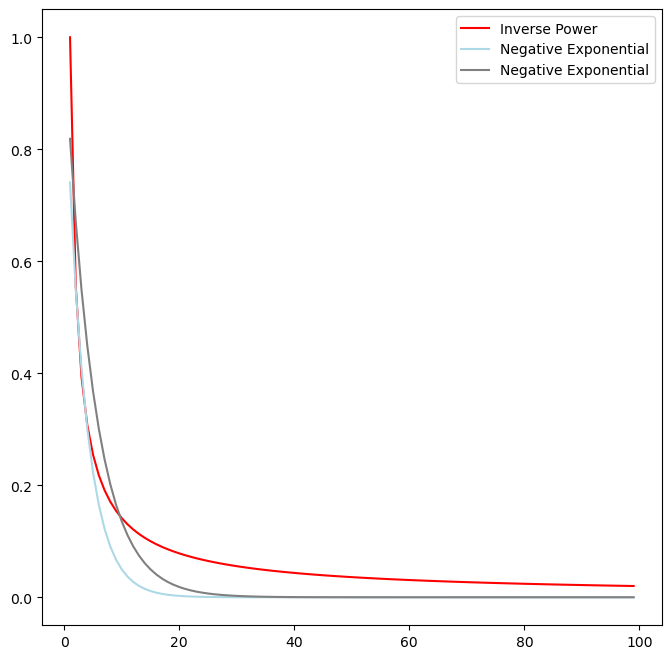

In [32]:
# Now let's consider some model tweaks.
# Starting with distance decay.
# Let's graph the distance decay parameters to get a feel for how they work.
xs = np.arange(1,100,1)
# inverse 0.85 power
y_inv_power = np.power(xs,-0.85)
# negative exponential, beta = 0.3
y_neg_exp_point3 = np.exp(-0.3*xs)
# negative exponential, beta = 0.2
y_neg_exp_point1 = np.exp(-0.2*xs)

# Now a plot.
f, ax = plt.subplots(figsize=(8,8))
ax.plot(xs,y_inv_power, label = "Inverse Power", color = "red")
ax.plot(xs,y_neg_exp_point3, label = 'Negative Exponential', color = "lightblue")
ax.plot(xs,y_neg_exp_point1, label = 'Negative Exponential', color = "gray")
ax.legend();

### 计算新的A_i, reconstruct the flow

In [90]:
#calculate some new Dj^gamma and d_ij^beta values
# Dj2_gamma = data["jobs"]**gamma
beta = 0.0002
dist_beta = np.exp(data['distance']*-beta)
#calcualte the first stage of the Ai values
data["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data.groupby(["origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i4"}, inplace=True)
#and write the A_i values back into the dataframe
data = data.merge(A_i, left_on="origin", right_index=True, how="left")
data.head()

,origin,destination,flows,population,jobs,distance,log_jobs,log_distance,O_i,D_j,...,A_i2,prodsimest4,A_i4_x,simest_B,A_i5,simest_B2,A_i6,simest_B3,A_i4_y,A_i4
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,599,78549,...,0.000097,83.0,0.000108,63.0,3.507011e+43,0.0,0.000192,22.0,0.000108,0.000108
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,599,442,...,0.000097,2.0,0.000108,1.0,3.507011e+43,0.0,0.000192,0.0,0.000108,0.000108
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,599,665,...,0.000097,4.0,0.000108,4.0,3.507011e+43,0.0,0.000192,3.0,0.000108,0.000108
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,599,58772,...,0.000097,63.0,0.000108,93.0,3.507011e+43,0.0,0.000192,60.0,0.000108,0.000108
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,599,15428,...,0.000097,60.0,0.000108,60.0,3.507011e+43,0.0,0.000192,69.0,0.000108,0.000108


Now we have some new $A_i$'s, let's generate some new scenario flow estimates...

In [91]:
data["simest_B"] = data["A_i4"]*data["O_i"]*Dj2_gamma*dist_beta
#round
data["simest_B"] = round(data["simest_B"])

datamat_B = data.pivot_table(values ="simest_B", index="origin", columns = "destination",
                            aggfunc=np.sum, margins=True)
datamat_B

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,10.0,9.0,NaN,18.0,0.0,NaN,12.0,...,10.0,2.0,1.0,24.0,NaN,0.0,NaN,0.0,NaN,3749.0
Aldgate,NaN,NaN,1.0,NaN,43.0,NaN,NaN,0.0,NaN,29.0,...,1.0,NaN,2.0,1.0,NaN,0.0,NaN,0.0,NaN,2877.0
Aldgate East,NaN,NaN,1.0,47.0,NaN,NaN,0.0,0.0,NaN,30.0,...,1.0,0.0,2.0,1.0,NaN,1.0,NaN,0.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,38.0,52.0,NaN,NaN,NaN,NaN,26.0,...,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4862.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,1.0,17.0,17.0,NaN,0.0,NaN,NaN,32.0,...,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [94]:
#calculate some new Dj^gamma and d_ij^beta values
# Dj2_gamma = data["jobs"]**gamma
beta = 0.0004
dist_beta = np.exp(data['distance']*-beta)
#calcualte the first stage of the Ai values
data["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data.groupby(["origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i6"}, inplace=True)
#and write the A_i values back into the dataframe
data = data.merge(A_i, left_on="origin", right_index=True, how="left")
data.head()

,origin,destination,flows,population,jobs,distance,log_jobs,log_distance,O_i,D_j,...,A_i4_x,simest_B,A_i5,simest_B2,A_i6_x,simest_B3,A_i4_y,A_i4,A_i6_y,A_i6
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,599,78549,...,0.000108,63.0,3.507011e+43,0.0,0.000192,22.0,0.000108,0.000108,0.000192,0.000192
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,599,442,...,0.000108,1.0,3.507011e+43,0.0,0.000192,0.0,0.000108,0.000108,0.000192,0.000192
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,599,665,...,0.000108,4.0,3.507011e+43,0.0,0.000192,3.0,0.000108,0.000108,0.000192,0.000192
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,599,58772,...,0.000108,93.0,3.507011e+43,0.0,0.000192,60.0,0.000108,0.000108,0.000192,0.000192
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,599,15428,...,0.000108,60.0,3.507011e+43,0.0,0.000192,69.0,0.000108,0.000108,0.000192,0.000192


In [95]:
data["simest_B3"] = data["A_i6"]*data["O_i"]*Dj2_gamma*dist_beta
#round
data["simest_B3"] = round(data["simest_B3"])

datamat_B3 = data.pivot_table(values ="simest_B3", index="origin", columns = "destination",
                            aggfunc=np.sum, margins=True)
datamat_B3

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1221.0
Acton Town,NaN,NaN,NaN,1.0,1.0,NaN,30.0,0.0,NaN,2.0,...,2.0,1.0,0.0,31.0,NaN,0.0,NaN,0.0,NaN,3740.0
Aldgate,NaN,NaN,0.0,NaN,65.0,NaN,NaN,0.0,NaN,29.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,2880.0
Aldgate East,NaN,NaN,0.0,72.0,NaN,NaN,0.0,0.0,NaN,29.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,13.0,24.0,NaN,NaN,NaN,NaN,6.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4859.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,0.0,5.0,5.0,NaN,0.0,NaN,NaN,17.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3090.0


In [99]:
#calculate some new Dj^gamma and d_ij^beta values
# Dj2_gamma = data["jobs"]**gamma
beta = 0.2
dist_beta = np.exp(data['distance']*-beta)
#calcualte the first stage of the Ai values
data["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data.groupby(["origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i5"}, inplace=True)
#and write the A_i values back into the dataframe
data = data.merge(A_i, left_on="origin", right_index=True, how="left")
data.head()

,origin,destination,flows,population,jobs,distance,log_jobs,log_distance,O_i,D_j,...,A_i5_x,simest_B2,A_i6_x,simest_B3,A_i4_y,A_i4,A_i6_y,A_i6,A_i5_y,A_i5
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,599,78549,...,3.507011e+43,0.0,0.000192,22.0,0.000108,0.000108,0.000192,0.000192,3.507011e+43,3.507011e+43
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,599,442,...,3.507011e+43,0.0,0.000192,0.0,0.000108,0.000108,0.000192,0.000192,3.507011e+43,3.507011e+43
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,599,665,...,3.507011e+43,0.0,0.000192,3.0,0.000108,0.000108,0.000192,0.000192,3.507011e+43,3.507011e+43
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,599,58772,...,3.507011e+43,0.0,0.000192,60.0,0.000108,0.000108,0.000192,0.000192,3.507011e+43,3.507011e+43
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,599,15428,...,3.507011e+43,0.0,0.000192,69.0,0.000108,0.000108,0.000192,0.000192,3.507011e+43,3.507011e+43


In [100]:
data["simest_B2"] = data["A_i5"]*data["O_i"]*Dj2_gamma*dist_beta
#round
data["simest_B2"] = round(data["simest_B2"])

datamat_B2 = data.pivot_table(values ="simest_B2", index="origin", columns = "destination",
                            aggfunc=np.sum, margins=True)
datamat_B2

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3745.0
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,2886.0
Aldgate East,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


## Analysis 10'
Discuss how the flows change for the 3 different situations: scenario A, and scenario B with two selections of parameters. Which scenario would have more impact in the redistribution of flows? 
Explain and justify your answers using the results of the analysis.

Asuumption: 0.0002是可接受范围内的增加，不足以影响工作的选择，出行规律不变，人们依旧愿意出门通勤，。
0.2是人们无法接受的出行成本，可能影响了工作的选择，例如出行成本与工资相当了

### flow change measure

In [115]:
# 将dataframe里的NA值替换为0
df = datamat.fillna(0)  #observed data
df1 = datamat1.fillna(0)  #observed data
df5 = datamat5.fillna(0)  #Scenario A
dfB = datamat_B.fillna(0)  #Scenario B
dfB2 = datamat_B2.fillna(0)  #Scenario B2
dfB3 = datamat_B3.fillna(0)  #Scenario B3
# 将dataframe转换为array
datamat_array = np.array(df)
datamat1_array = np.array(df1)
datamat5_array = np.array(df5)
datamat_B_array = np.array(dfB)
datamat_B2_array = np.array(dfB2)
datamat_B3_array = np.array(dfB3)

In [116]:
# Scenario A
# 计算出F1和F0中对应位置的数值差的绝对值，即OD矩阵flow的绝对变化量
abs_flow_change = np.abs(datamat5_array - datamat1_array)

# 按照需要进行求和或取平均
total_abs_flow_change = np.sum(abs_flow_change)  # 求和
avg_abs_flow_change = np.mean(abs_flow_change)  # 取平均

print("Scenario A OD矩阵flow的总体绝对变化量为：", total_abs_flow_change)
print("Scenario A OD矩阵flow的平均绝对变化量为：", avg_abs_flow_change)

Scenario A OD矩阵flow的总体绝对变化量为： 73712.0
Scenario A OD矩阵flow的平均绝对变化量为： 0.4630121670090012


In [117]:
# Scenario B1 beta=0.0002
# 计算出F1和F0中对应位置的数值差的绝对值，即OD矩阵flow的绝对变化量
abs_flow_change2 = np.abs(datamat_B_array - datamat1_array)

# 按照需要进行求和或取平均
total_abs_flow_change2 = np.sum(abs_flow_change2)  # 求和
avg_abs_flow_change2 = np.mean(abs_flow_change2)  # 取平均

print("Scenario B OD矩阵flow的总体绝对变化量为：", total_abs_flow_change2)
print("Scenario B OD矩阵flow的平均绝对变化量为：", avg_abs_flow_change2)

Scenario B OD矩阵flow的总体绝对变化量为： 271164.0
Scenario B OD矩阵flow的平均绝对变化量为： 1.7032807582866942


In [118]:
# Scenario B2 beta=0.2
# 计算出F1和F0中对应位置的数值差的绝对值，即OD矩阵flow的绝对变化量
abs_flow_change3 = np.abs(datamat_B2_array - datamat_array)

# 按照需要进行求和或取平均
total_abs_flow_change3 = np.sum(abs_flow_change3)  # 求和
avg_abs_flow_change3 = np.mean(abs_flow_change3)  # 取平均

print("Scenario B2 OD矩阵flow的总体绝对变化量为：", total_abs_flow_change3)
print("Scenario B2 OD矩阵flow的平均绝对变化量为：", avg_abs_flow_change3)

Scenario B2 OD矩阵flow的总体绝对变化量为： 5075120.0
Scenario B2 OD矩阵flow的平均绝对变化量为： 31.878694229307605


In [119]:
# Scenario B3 beta=0.0004
# 计算出F1和F0中对应位置的数值差的绝对值，即OD矩阵flow的绝对变化量
abs_flow_change4 = np.abs(datamat_B3_array - datamat_array)

# 按照需要进行求和或取平均
total_abs_flow_change4 = np.sum(abs_flow_change4)  # 求和
avg_abs_flow_change4 = np.mean(abs_flow_change4)  # 取平均

print("Scenario B3 OD矩阵flow的总体绝对变化量为：", total_abs_flow_change4)
print("Scenario B3 OD矩阵flow的平均绝对变化量为：", avg_abs_flow_change4)

Scenario B3 OD矩阵flow的总体绝对变化量为： 1929652.0
Scenario B3 OD矩阵flow的平均绝对变化量为： 12.120853512226683


### Grid Map

C:\Users\JinJiang\AppData\Local\Temp\ipykernel_17968\2791971481.py:3: RuntimeWarning: divide by zero encountered in log
  matrix_log = np.log(abs_flow_change)


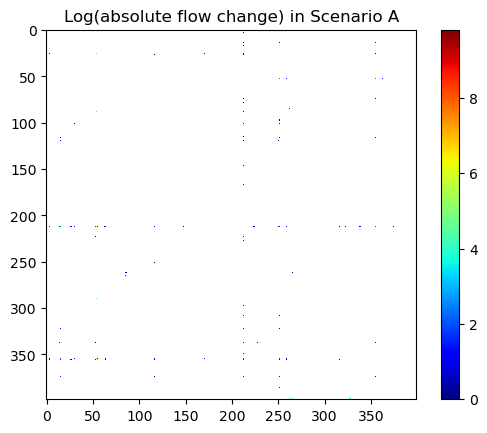

In [130]:
# Scenario A
# 对数变换
matrix_log = np.log(abs_flow_change)

plt.title("Log(absolute flow change) in Scenario A")
ax.set_xlabel('station nodes id')
ax.set_ylabel('station nodes id')
plt.imshow(matrix_log, cmap='jet')
plt.colorbar()
plt.savefig('./Log(absolute flow change) in Scenario A.png',dpi=300)
plt.show()

C:\Users\JinJiang\AppData\Local\Temp\ipykernel_17968\3677821261.py:2: RuntimeWarning: divide by zero encountered in log
  matrix_log2 = np.log(abs_flow_change2)


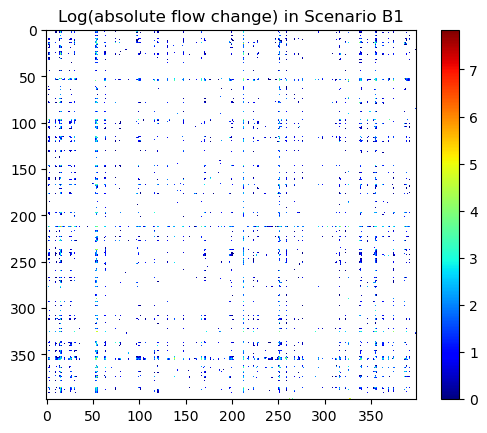

In [131]:
# Scenario B beta=0.0002
matrix_log2 = np.log(abs_flow_change2)

plt.title("Log(absolute flow change) in Scenario B1")
ax.set_xlabel('station nodes id')
ax.set_ylabel('station nodes id')
plt.imshow(matrix_log2, cmap='jet')
plt.colorbar()
plt.savefig('./Log(absolute flow change) in Scenario B1.png',dpi=300)
plt.show()


C:\Users\JinJiang\AppData\Local\Temp\ipykernel_17968\3201593730.py:2: RuntimeWarning: divide by zero encountered in log
  matrix_log3 = np.log(abs_flow_change2)


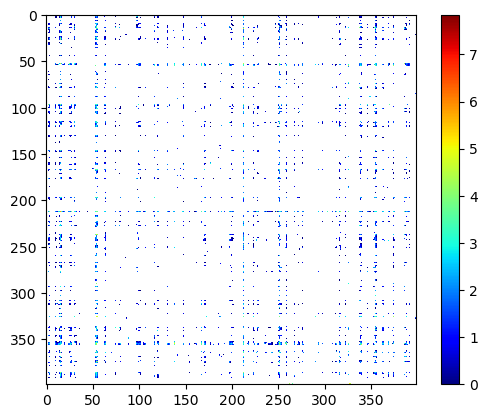

In [122]:
# Scenario B beta=0.2
matrix_log3 = np.log(abs_flow_change2)

plt.imshow(matrix_log3, cmap='jet')
plt.colorbar()
plt.show()


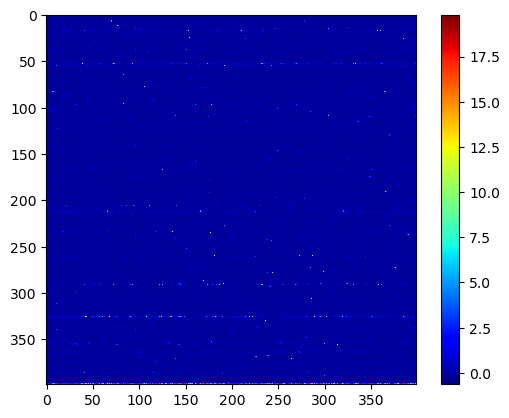

In [123]:
# 标准化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
matrix_std = scaler.fit_transform(abs_flow_change)


plt.imshow(matrix_std, cmap='jet')
plt.colorbar()
plt.show()

### Plot tube map

In [110]:
import networkx as nx
G = nx.read_graphml('../Part1/london.graph')
print(nx.info(G))

Graph with 401 nodes and 467 edges


C:\Users\JinJiang\AppData\Local\Temp\ipykernel_17968\494226769.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [111]:
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)})

In [112]:
flows = { 'flows':[]}
# now I want to get all the length value from the edges, and store them in a dictionary
for edge in G.edges():
    # flows['edge'].append(edge)
    flows['flows'].append(G.edges[edge]['flows'])

# create a dataframe from the dictionary
flows_df = pd.DataFrame(flows)
flows_df.tail()

,flows
462,11234
463,13469
464,15935
465,17445
466,18598


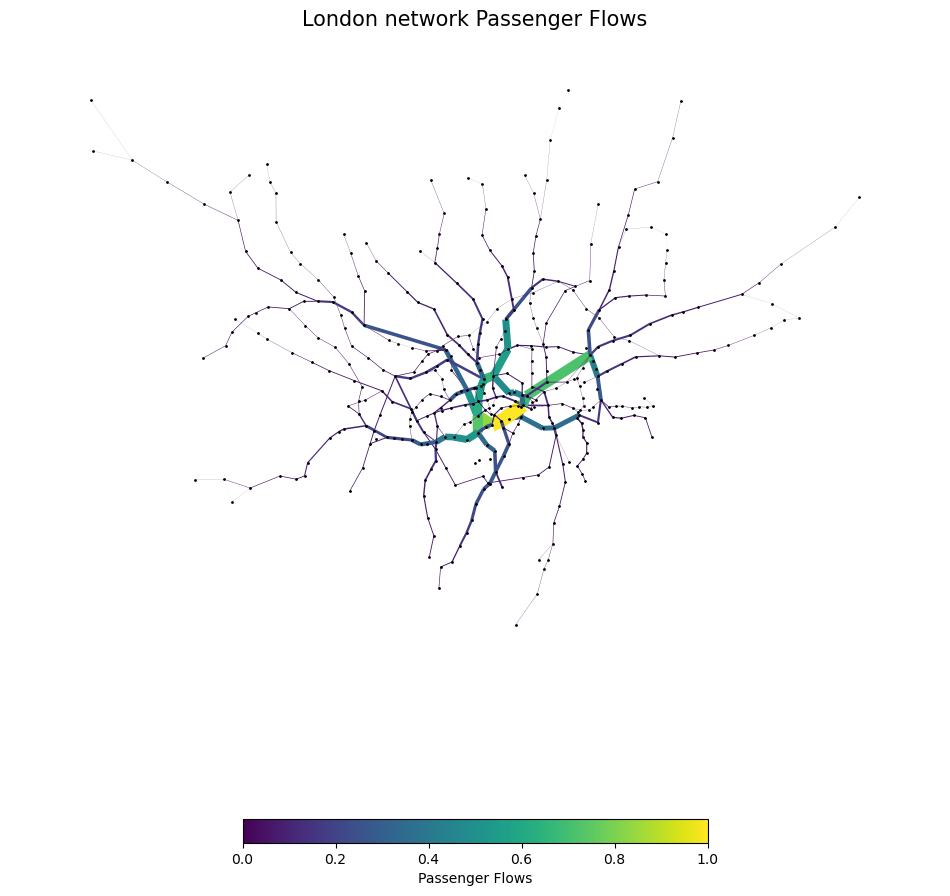

In [113]:
#plot our calcuated flows
max_flow = flows_df['flows'].max()

flow_color=[(i[2]['flows']/max_flow ) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max_flow *10) for i in G.edges(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

# pos=nx.spring_layout(X)
pos = nx.get_node_attributes(G, 'coords')

edg= nx.draw_networkx_edges(G, pos, edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)


plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

### Top stations in flow changes

In [144]:
df_change_A = df5-df1
df_change_A.tail()

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Woodford,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.0
Woodgrange Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Woodside Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
Woolwich Arsenal,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0
All,19.0,0.0,11.0,89.0,110.0,40.0,4.0,1.0,0.0,95.0,...,16.0,1.0,18.0,11.0,0.0,13.0,0.0,5.0,78.0,50.0
